# YOLOv5 Face Mask Detection 🧪
This notebook walks through loading a trained YOLOv5 model and testing it on images.

In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET

from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [88]:
def download_dataset(kaggle_json_path, download_path="data"):
    os.environ['KAGGLE_CONFIG_DIR'] = os.path.dirname(kaggle_json_path)
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files("andrewmvd/face-mask-detection", path=download_path, unzip=True)
    print("✅ Dataset downloaded and extracted to", download_path)

In [ ]:
def organize_dataset(
    annotations_dir='../data/annotations',
    images_dir='../data/images',
    output_dir='../dataset'
):
    labels_map = {
        'with_mask': 'with_mask',
        'without_mask': 'without_mask',
        'mask_weared_incorrect': 'mask_weared_incorrect'
    }

    # Create a class folder if it doesn't already exist
    for label in labels_map.values():
        os.makedirs(os.path.join(output_dir, label), exist_ok=True)

    # Read the XML file and move the images to the class folder as labeled
    for xml_file in os.listdir(annotations_dir):
        if not xml_file.endswith('.xml'):
            continue

        xml_path = os.path.join(annotations_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        filename = root.find('filename').text
        label = root.find('object').find('name').text

        if label in labels_map:
            src_image_path = os.path.join(images_dir, filename)
            dst_image_path = os.path.join(output_dir, labels_map[label], filename)

            if os.path.exists(src_image_path):
                shutil.copy(src_image_path, dst_image_path)

    print("✅ The dataset has been moved to the per-class folder in the:", output_dir)

In [90]:
def create_model(input_shape=(224, 224, 3), num_classes=3):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
def plot_training(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    # plt.savefig("visualizations/training_plot.png")
    plt.show()

def evaluate_model(model, val_gen):
    val_gen.reset()
    preds = model.predict(val_gen, verbose=1)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_gen.classes
    class_labels = list(val_gen.class_indices.keys())

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_gen.class_indices, yticklabels=val_gen.class_indices)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    print("Confusion Matrix:")
    print(cm)

In [92]:
# Download dataset
kaggle_json_path = "../kaggle.json"  # Adjust path if needed
if not os.path.exists("../data/annotations"):  # simple check if already extracted
    download_dataset(kaggle_json_path)

In [ ]:
# Preprocessing
organize_dataset()

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    '../dataset/',  # fixed path
    target_size=img_size,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    '../dataset/',  # fixed path
    target_size=img_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    "../dataset/",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

✅ Dataset telah dipindahkan ke folder per kelas di: ../dataset
Found 684 images belonging to 3 classes.
Found 169 images belonging to 3 classes.


In [ ]:
# Model
model = create_model(input_shape=img_size + (3,), num_classes=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
# Training
history = model.fit(train_gen, validation_data=val_gen, epochs=10)
if not os.path.exists("../models"):
    os.makedirs("../models")

model.save("../models/mask_detector.h5")

Epoch 1/10
22/22 [==============================] - 74s 3s/step - loss: 0.0074 - accuracy: 0.9985 - val_loss: 1.1839 - val_accuracy: 0.8225
Epoch 2/10
22/22 [==============================] - 43s 2s/step - loss: 0.0035 - accuracy: 0.9985 - val_loss: 1.6268 - val_accuracy: 0.8225
Epoch 3/10
22/22 [==============================] - 47s 2s/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 1.5637 - val_accuracy: 0.8343
Epoch 4/10
22/22 [==============================] - 49s 2s/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.6330 - val_accuracy: 0.8284
Epoch 5/10
22/22 [==============================] - 44s 2s/step - loss: 0.0098 - accuracy: 0.9971 - val_loss: 1.9291 - val_accuracy: 0.8343
Epoch 6/10
22/22 [==============================] - 45s 2s/step - loss: 0.0062 - accuracy: 0.9985 - val_loss: 1.6030 - val_accuracy: 0.8166
Epoch 7/10
22/22 [==============================] - 45s 2s/step - loss: 0.0063 - accuracy: 0.9985 - val_loss: 1.5921 - val_accuracy: 0.8107
Epoch 8/10
22/22 [==

c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


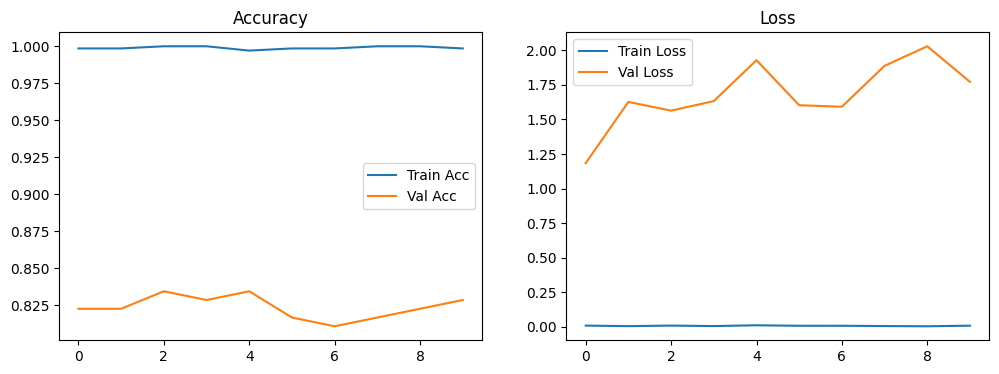

6/6 [==============================] - 6s 992ms/step
Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.00      0.00      0.00         7
            with_mask       0.82      0.97      0.89       139
         without_mask       0.25      0.04      0.07        23

             accuracy                           0.80       169
            macro avg       0.36      0.34      0.32       169
         weighted avg       0.71      0.80      0.74       169

Confusion Matrix:
[[  0   7   0]
 [  1 135   3]
 [  0  22   1]]


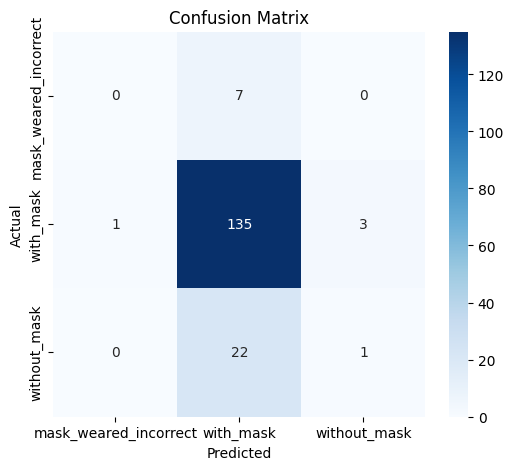

In [ ]:
# Evaluation
if not os.path.exists("../visualizations"):
    os.makedirs("../visualizations")

plot_training(history)
evaluate_model(model, test_gen)

In [ ]:
loss, acc = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")